In [69]:
'''You are provided with daily historical sales data. 
The task is to forecast the total amount of products sold in every shop for the test set. 
Note that the list of shops and products slightly changes every month. 
Creating a robust model that can handle such situations is part of the challenge.

Link: https://www.kaggle.com/c/competitive-data-science-predict-future-sales

My assumptions:
- I do not care about russian names, I do not understand them. I will stick to IDs. 
-- On data load will skip dictionary names: item_categories.csv and shops.csv
- Minus "-" sign at item_cnt_day means that product was returned.
- Because of negative values for target value we cannot transform using log function.
- I'm intrested in shop x item x month aggregations.
- Price can change in month so I need to take mean, median, max, min and std dev.
- For target value sum should be enough (to be decided if for more complex analysis is the case).
- For POC model I will work on:
-- shop_id = 31
-- item_id = 20949
'''
%reset

In [70]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
# 
FEATURES_ORIGINAL = [
    'date',
    'date_block_num',
    'shop_id',
    'item_id',
    'item_category_id',
    'item_price']
TARGET = ['item_cnt_day']
TARGET_STR = ''.join(['item_cnt_day'])

def get_train():
    train_raw = pd.read_csv('sales_train.csv')
    items_raw = pd.read_csv('items.csv')    
    train = pd.merge(left=train_raw, right=items_raw, on='item_id', how='left')
    return train[FEATURES_ORIGINAL + TARGET]

def get_test():
    return pd.read_csv('test.csv')

In [223]:
train = get_train()
test = get_test()

def transfrom_train(train):
    # Remove date_block_num (it's useful, but I don't want to use it).
    train.drop('date_block_num', inplace=True, axis=1)
    
    # Add year, month, day columns.
    train['year'] = train['date'].apply(lambda x: x.split('.')[2])
    train['month'] = train['date'].apply(lambda x: x.split('.')[1])
    train['year_month'] = train['year'] + '_' + train['month']

    # Change ID's to qualitative - these will be my shop, item, category names.
    train.loc[:, 'shop_id'] = train['shop_id'].astype(object)
    train.loc[:, 'item_id'] = train['item_id'].astype(object)
    train.loc[:, 'item_category_id'] = train['item_category_id'].astype(object)
    
    # Aggregation.
    grouped = train.groupby(['year', 'month', 'year_month', 'shop_id', 'item_id'])
    train = grouped.agg({
        'item_price': ['mean', 'max', 'min', 'std'],
        'item_cnt_day': 'sum'
    }).reset_index()
    train_columns_new = []
    for upper, lower in list(train.columns):
        column = upper + '_' + lower if lower != '' else upper
        train_columns_new.append(column)    
    train.columns = train_columns_new
    
    return train

train = transfrom_train(train)

In [227]:
def get_train_sample(train):
    train_sample = train.loc[(train['shop_id'] == 31) & (train['item_id'] == 20949), :]
    return train_sample

train_sample = get_train_sample(train)

In [228]:
train_sample.head()

,year,month,year_month,shop_id,item_id,item_price_mean,item_price_max,item_price_min,item_price_std,item_cnt_day_sum
216552,2013,04,2013_04,31,20949,5.000000,5.0,5.000000,0.000000,13.0
270202,2013,05,2013_05,31,20949,5.000000,5.0,5.000000,0.000000,384.0
325007,2013,06,2013_06,31,20949,4.998039,5.0,4.941176,0.010740,763.0
383106,2013,07,2013_07,31,20949,4.999390,5.0,4.984000,0.002903,799.0
441060,2013,08,2013_08,31,20949,5.000000,5.0,5.000000,0.000000,820.0


In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 8 columns):
date                object
shop_id             object
item_id             object
item_category_id    object
item_price          float64
item_cnt_day        float64
year                object
month               object
dtypes: float64(2), object(6)
memory usage: 281.6+ MB


In [15]:
test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


### Data analysis

In [67]:
# Check NULLs in train.
train.isnull().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_category_id    0
item_price          0
item_cnt_day        0
year                0
month               0
day                 0
dtype: int64

In [68]:
# Check NULLs in test.
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


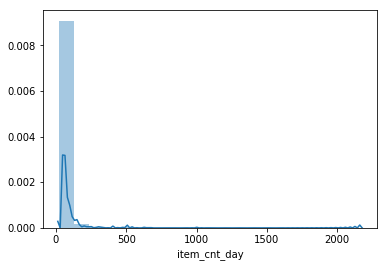

In [131]:
# Take a look target variable.
data = train[TARGET_STR]
data = train.loc[train[TARGET_STR] > 20, TARGET_STR]
sns.distplot(data, bins=20, kde=True)

In [229]:
# Find record for data modeling.
test = train.groupby(['year', 'shop_id']).agg({'item_cnt_day_sum': 'sum'}).reset_index()
test = train.sort_values(by='item_cnt_day_sum', ascending=False)
test2 = test.head(100).groupby(['shop_id', 'item_id']).agg({'item_cnt_day_sum': 'count'}).reset_index().sort_values(by='item_cnt_day_sum', ascending=False)
test2.head()

,shop_id,item_id,item_cnt_day_sum
16,31,20949,20
11,25,20949,15
19,54,20949,13
14,28,20949,13
13,27,20949,4


In [1]:
# Plot train_sample.
sns.pointplot(x='year_month', y='item_cnt_day_sum', data=train_sample)

NameError: name 'sns' is not defined